In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('/content/sample_data/newly_generated_district_rows_2021_2022.csv')

In [ ]:
print(df.head())

   week_start  iso_year  iso_week week_index      state          district  \
0  04-01-2021      2021         1   2021-W01      Assam      Kamrup Metro   
1  04-01-2021      2021         1   2021-W01      Assam         Dibrugarh   
2  04-01-2021      2021         1   2021-W01      Assam            Jorhat   
3  04-01-2021      2021         1   2021-W01      Assam            Nagaon   
4  04-01-2021      2021         1   2021-W01  Meghalaya  East Khasi Hills   

   rainfall_mm  turbidity_NTU  sanitation_index  temp_C  DO_mg_L    pH  \
0          6.6           2.53              0.52    25.5     4.56  6.81   
1          2.7           5.84              0.58    27.3     6.70  8.17   
2         11.4           3.04              0.51    30.6     1.50  6.62   
3          7.3           5.40              0.53    31.8     7.16  7.56   
4          2.6           0.50              0.65    17.6     4.80  8.51   

   conductivity_uS_cm  BOD_mg_L  nitrate_mg_L  fecal_coliform_MPN_100mL  \
0               3

In [ ]:
df.isnull().sum()

,0
week_start,0
iso_year,0
iso_week,0
week_index,0
state,0
district,0
rainfall_mm,0
turbidity_NTU,0
sanitation_index,0
temp_C,0


In [ ]:
print(df['state'].unique())

['Assam' 'Meghalaya' 'Manipur' 'Mizoram' 'Nagaland' 'Tripura' 'Sikkim'
 'Arunachal Pradesh']


In [ ]:
print(len(df['district'].unique()))

32


In [ ]:
df['week_start'] = pd.to_datetime(df['week_start'], format="%d-%m-%Y")


In [ ]:
print(df['outbreak_label'].unique())

['High' 'Medium' 'Low']


In [ ]:
df.drop(columns=['week_index'],inplace=True)
df.drop(columns=['cases_week'],inplace=True)
df['outbreak_label'] = df['outbreak_label'].map({'High': 2, 'Medium': 1, 'Low': 0})
df= pd.get_dummies(df, columns=['state'], drop_first=True)
df= pd.get_dummies(df, columns=['district'], drop_first=True)
print(df.head())

  week_start  iso_year  iso_week  rainfall_mm  turbidity_NTU  \
0 2021-01-04      2021         1          6.6           2.53   
1 2021-01-04      2021         1          2.7           5.84   
2 2021-01-04      2021         1         11.4           3.04   
3 2021-01-04      2021         1          7.3           5.40   
4 2021-01-04      2021         1          2.6           0.50   

   sanitation_index  temp_C  DO_mg_L    pH  conductivity_uS_cm  ...  \
0              0.52    25.5     4.56  6.81               379.0  ...   
1              0.58    27.3     6.70  8.17               344.0  ...   
2              0.51    30.6     1.50  6.62               157.5  ...   
3              0.53    31.8     7.16  7.56                79.2  ...   
4              0.65    17.6     4.80  8.51               145.1  ...   

   district_South Sikkim  district_South Tripura  \
0                  False                   False   
1                  False                   False   
2                  False        

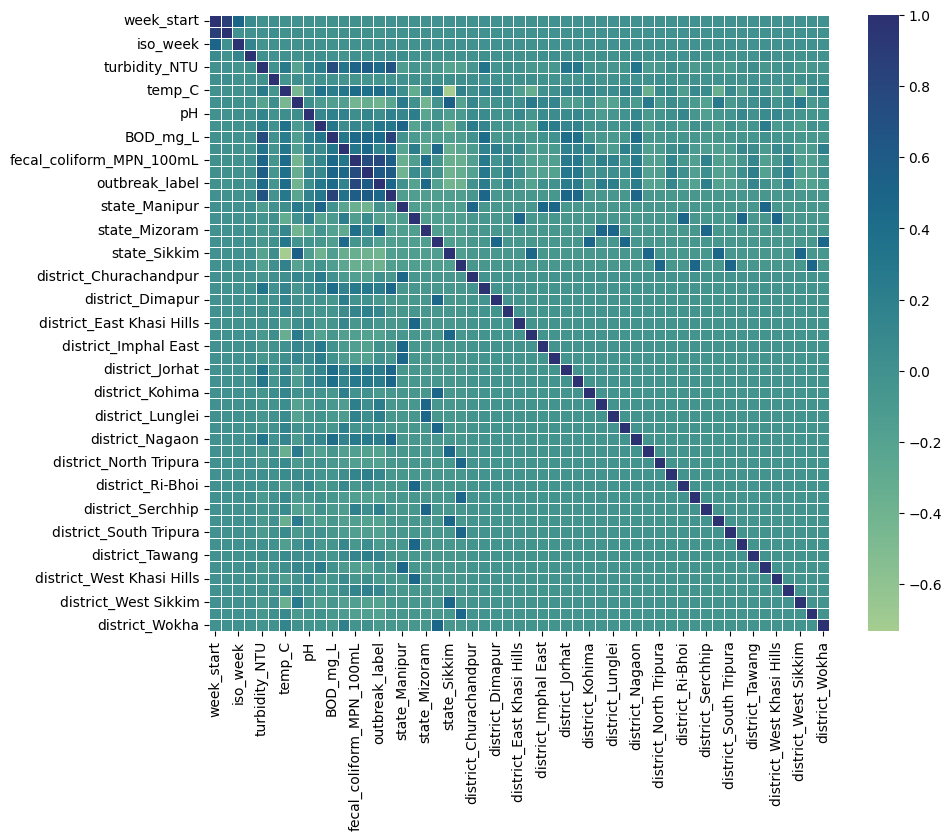

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=False, fmt=".2f", linewidths=0.5,cmap="crest")
plt.show()

If i put a limit on the values then when in some cases the rainfall is high and other cases are low then the prediction might give wrong result. Here the model directly predicts the outbreak so no issue. Had it been predicting some attributes then based on that prediction we can make limits to predict the  outbreak.

In [ ]:
df.drop(columns=['week_start'],inplace=True)

In [ ]:
print(df['outbreak_label'].unique())

[2 1 0]


In [ ]:
print(df['outbreak_label'].isnull().sum())

0


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Features and target
X = df.drop(columns=['outbreak_label'])
y = df['outbreak_label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scaling (important for some models like Logistic Regression, SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(eval_metric='mlogloss', use_label_encoder=False, random_state=42)
}

for name, model in models.items():
    if name in ["Logistic Regression", "SVM"]:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))
    print("-"*60)


Logistic Regression Accuracy: 0.8919
              precision    recall  f1-score   support

           0       0.92      0.91      0.91       266
           1       0.82      0.80      0.81       187
           2       0.91      0.95      0.93       213

    accuracy                           0.89       666
   macro avg       0.89      0.89      0.89       666
weighted avg       0.89      0.89      0.89       666

------------------------------------------------------------
SVM Accuracy: 0.8273
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       266
           1       0.78      0.64      0.70       187
           2       0.87      0.91      0.89       213

    accuracy                           0.83       666
   macro avg       0.82      0.81      0.82       666
weighted avg       0.82      0.83      0.82       666

------------------------------------------------------------
Random Forest Accuracy: 0.9925
              precision    

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [14:05:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.9955
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       266
           1       0.99      0.99      0.99       187
           2       1.00      1.00      1.00       213

    accuracy                           1.00       666
   macro avg       1.00      1.00      1.00       666
weighted avg       1.00      1.00      1.00       666

------------------------------------------------------------


XGBoost is the best model for prediction

In [ ]:
import joblib
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", XGBClassifier(eval_metric='mlogloss', use_label_encoder=False, random_state=42))
])
pipeline.fit(X_train, y_train)
joblib.dump(pipeline, "outbreak_model.pkl")

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [14:08:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


['outbreak_model.pkl']

model saved as outbreak_model.plk

In [ ]:
print(df.head(3))

   iso_year  iso_week  rainfall_mm  turbidity_NTU  sanitation_index  temp_C  \
0      2021         1          6.6           2.53              0.52    25.5   
1      2021         1          2.7           5.84              0.58    27.3   
2      2021         1         11.4           3.04              0.51    30.6   

   DO_mg_L    pH  conductivity_uS_cm  BOD_mg_L  ...  district_South Sikkim  \
0     4.56  6.81               379.0      2.20  ...                  False   
1     6.70  8.17               344.0      7.69  ...                  False   
2     1.50  6.62               157.5      2.68  ...                  False   

   district_South Tripura  district_South West Garo Hills  district_Tawang  \
0                   False                           False            False   
1                   False                           False            False   
2                   False                           False            False   

   district_Thoubal  district_West Khasi Hills  district_

In [ ]:
print(df.size)
print(df.shape)

173056
(3328, 52)


In [ ]:
feature_columns = X.columns.tolist()
joblib.dump((pipeline, feature_columns), "outbreak_model.pkl")

pipeline, feature_columns = joblib.load("outbreak_model.pkl")
new_data = {
    "iso_week": [30],
    "iso_year": [120],
    "state": ['Assam'],
    "district": ["Jorhat"],
    "rainfall_mm": [6.6],
    "turbidity_NTU": [5.84],
    "sanitation_index":[0.56],
    "temp_C":[27],
    "DO_mg_L":[6.13],
    "pH":[8.17],
    "conductivity_uS_cm":[344],
    "BOD_mg_L":[7.69],
    "nitrate_mg_L":[3.13],
    "fecal_coliform_MPN_100mL":[1880],
    "total_coliform_MPN_100mL":[1259],
}
new_df = pd.DataFrame(new_data)
new_df = pd.get_dummies(new_df)
new_df = new_df.reindex(columns=feature_columns, fill_value=0)
prediction = pipeline.predict(new_df)
labels = {0: "Low", 1: "Medium", 2: "High"}
print("Predicted outbreak level:", labels[prediction[0]])

Predicted outbreak level: High
